In [21]:
# imports
import pandas as pd
import numpy as np
from sklearn import linear_model, datasets
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
# turn csv files into dfs
POI_df = pd.read_csv('../data/POI_df.csv', low_memory=False)
top_cat_count_per_station_df = pd.read_csv('../data/top_cat_count_per_station.csv')

In [3]:
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating,avg_rating_around_station,num_categories_near_station
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,8.0,1.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000,7.7,45
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238,7.7,45
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304,7.7,45
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000,7.7,45
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,15.0,2.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000,7.7,45


# Building a regression model.

### First, let's only grab the numerical columns that we will use for our regression model and make a first pass at using the OLS model builder

In [4]:
LRM_POI_df = POI_df[['POI_latitude', 'POI_longitude', 'FS_distance', 'FS_rating', 'FS_total_ratings',
                     'FS_popularity', 'FS_price_rating', 'yelp_distance', 'yelp_rating', 
                     'yelp_total_ratings', 'yelp_price_rating', 'station_latitude', 'station_longitude', 
                     'avg rating', 'avg_rating_around_station', 'num_categories_near_station']]

In [5]:
X = LRM_POI_df
y = POI_df['number of bikes']

In [6]:
X = sm.add_constant(X) # adding a constant
lin_reg = sm.OLS(y,X)

In [7]:
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:        number of bikes   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     361.1
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:36:33   Log-Likelihood:            -1.8483e+05
No. Observations:               56282   AIC:                         3.697e+05
Df Residuals:                   56265   BIC:                         3.699e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### Now let's look at the correlations between all of our predictors for multicollinearity.

#### I suspect that we have some multicollinearity between many of our independent variables.  Specifically between distances and longitude and latitude since distance is calculated by comparing coordinates. We also have multicollinearity between the FS_rating, yelp_rating and the avg_rating since avg_rating used these two values in the calculations of it.  Lastly, price ratings between both FS and yelp will be very similar.


In [8]:
X.corr(numeric_only = True)

,const,POI_latitude,POI_longitude,FS_distance,FS_rating,FS_total_ratings,FS_popularity,FS_price_rating,yelp_distance,yelp_rating,yelp_total_ratings,yelp_price_rating,station_latitude,station_longitude,avg rating,avg_rating_around_station,num_categories_near_station
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
POI_latitude,NaN,1.000000,0.250068,0.126334,-0.221720,-0.128402,-0.133427,-0.063674,0.126363,-0.222293,-0.128930,-0.065600,0.989812,0.248273,-0.223662,-0.568852,-0.281510
POI_longitude,NaN,0.250068,1.000000,-0.024648,-0.015791,0.025567,0.017494,0.007780,-0.024957,-0.015369,0.025211,0.004070,0.254423,0.994507,-0.014633,-0.038027,-0.099458
FS_distance,NaN,0.126334,-0.024648,1.000000,-0.110915,0.023323,-0.081304,-0.011043,0.999609,-0.108562,0.018840,-0.013689,0.123443,-0.024645,-0.112377,-0.252205,-0.135588
FS_rating,NaN,-0.221720,-0.015791,-0.110915,1.000000,0.174010,0.405639,0.153705,-0.110979,0.995891,0.176557,0.156970,-0.220364,-0.015857,0.991376,0.385455,0.237252
FS_total_ratings,NaN,-0.128402,0.025567,0.023323,0.174010,1.000000,0.161770,0.223231,0.023249,0.171669,0.987941,0.219588,-0.123880,0.024809,0.173637,0.170110,0.075222
FS_popularity,NaN,-0.133427,0.017494,-0.081304,0.405639,0.161770,1.000000,0.105124,-0.081532,0.402509,0.162754,0.106905,-0.129850,0.015824,0.405690,0.203713,0.088477
FS_price_rating,NaN,-0.063674,0.007780,-0.011043,0.153705,0.223231,0.105124,1.000000,-0.010937,0.149821,0.230781,0.982095,-0.063813,0.007288,0.152748,0.158789,0.106188
yelp_distance,NaN,0.126363,-0.024957,0.999609,-0.110979,0.023249,-0.081532,-0.010937,1.000000,-0.108557,0.018763,-0.013649,0.123428,-0.024952,-0.112409,-0.252280,-0.135779
yelp_rating,NaN,-0.222293,-0.015369,-0.108562,0.995891,0.171669,0.402509,0.149821,-0.108557,1.000000,0.173819,0.152529,-0.220982,-0.015376,0.991330,0.386171,0.237944


### Removing the variables that have strong correlations and re-running the model

In [9]:
LRM_POI_df = POI_df[['FS_distance', 'FS_total_ratings', 'FS_popularity', 'FS_price_rating', 'yelp_total_ratings', 
                     'avg rating', 'avg_rating_around_station', 'num_categories_near_station']]

In [10]:
X = LRM_POI_df
y = POI_df['number of bikes']

X = sm.add_constant(X) # adding a constant
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:        number of bikes   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     195.5
Date:                Wed, 30 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:36:39   Log-Likelihood:            -1.8681e+05
No. Observations:               56282   AIC:                         3.736e+05
Df Residuals:                   56273   BIC:                         3.737e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

#### It appears that our R-squared has become worse after removing these variables.

### Let's try using backward elimination in a loop that will remove the worst P-values one at a time, until all the P-values are less than our 0.05 threshhold.

In [11]:
def backward_elimination(X, y, significance_level=0.05):
    cols = X.columns.tolist()
    
    while len(cols) > 0:
        
        model = sm.OLS(y, X[cols]).fit()
        max_pvalue = model.pvalues.idxmax()
        
        if model.pvalues[max_pvalue] > significance_level:
            cols.remove(max_pvalue)
        else:
            break
    return X[cols]

# Call the function to get the refined X
refined_X = backward_elimination(X, y)

### Now let's re-check our model with our refined list of predictors

In [23]:
lin_reg = sm.OLS(y,refined_X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:        number of bikes   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                          1.579e+04
Date:                Wed, 30 Aug 2023   Prob (F-statistic):                        0.00
Time:                        23:47:51   Log-Likelihood:                     -1.8681e+05
No. Observations:               56282   AIC:                                  3.736e+05
Df Residuals:                   56276   BIC:                                  3.737e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

### A few things to note about these results:
#### 1. The Adjusted R-Squared value went up substantially.

#### 2. The constant that was added to the model earlier was removed because of its large P-value.
While this might be an issue with other regression models, I believe it's okay that we eliminate it in this one.  Since our number of bikes CAN be zero and we would expect it to be zero if all of our predictors were zero, then having an intercept at 0 is acceptable.

#### 3. Some of the coefficients are quite low and negative.
Since this data is not normalized between 0 and 1, these coefficients are a little more difficult to "understand" as far as the impact the predictor has on our number of bikes, but I will attempt to discuss a couple of them to justify why (or why not) these predictors should be kept.

- The coefficient for FS_total_ratings is negative, which means that it has an inverse relationship with number of bikes.  In other words, as the total number of FS ratings increases, the number of bikes at the nearby station decreases (and vice-versa).  This is a surprising result, since we would not expect this to be the case, but the coefficient is very low (-0.0023).  When we look at the range of values that the FS_total_ratings could be, we see that it could be anywhere between 0 and 3752.  This means that the maximum impact this variable could make on the total number of bikes is $-0.0023 \times 3752 = -8.6296$ bikes.  That is, if every other predictor/independent variable stayed constant, a total of 3752 ratings would decrease the bike count by nearly 9 bikes.  On the other hand, that total number of ratings is only for a single POI, and not for the station itself.  If we really wanted to have a more meaningful value, it'd be the average total ratings around the station.  Since the overall average total ratings value is 120, the average total ratings would likely be similar.  Thus, only making a minor impact on the number of bikes (not even 1).

- The coefficent for FS_distance is very low as well, but positive.  This means that as the distance increases, the number of bikes increases.  However, we once again see a low coefficient, and with a maximum distance of 1000m we would see a maximum of $0.0011 \times 1000 = 1.1$ bikes change in the number of bikes.  Once again, the average distance that any POI is from these stations are not even close to 1000m, so this predictor appears to have little impact on our model.

- The coefficient for FS_price_rating is interesting.  It has an inverse relationship with the number of bikes, but in this case that might actually make some sense.  Now, this IS a categorical value (between 1 and 4, and 0 if no rating), where the lower the value, the "cheaper" the POI is.  A level 4 restaurant would be the most expensive.  So we could say that as the cost of the POIs decreases, in an area, the more bikes we can expect to be at the station.  It could be that the people who are looking to go to the more budget friendly POIs, are also more budget friendly when it comes to transportation.  So these locations with lower price ratings draw more bike-riders, hence, more bikes at the station.  However, because the price rating is so low, with a coefficient of -0.2094, this makes little impact on our number of bikes in the end.

- yelp_total_ratings has similar rationalle as the FS_total_ratings.

#### Before I offically choose to remove or keep any of these predictors in the model, I want to check my residuals to see whether they are normal and whether we have homoscedasticity, then I want to normalize my data and re-try the model to see the coefficients again.

### Checking Residuals for normalcy and homoscedasticity

<AxesSubplot:ylabel='Count'>

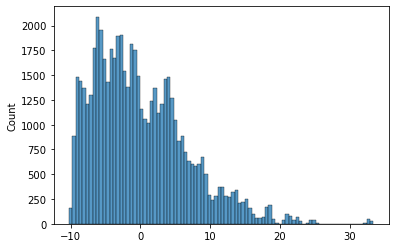

In [24]:
residuals = model.resid
sns.histplot(residuals)

In [25]:
scipy.stats.shapiro(residuals)

/Users/jlo/anaconda3/envs/LHL_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9403947591781616, pvalue=0.0)

#### NOTE: These residuals do not appear to be very normally distributed.  There's some normal attributes to this distribution, but it's not great.

### Checking homoscedasticity of our independent variables.

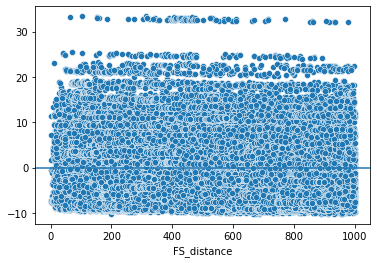

In [16]:
ax = sns.scatterplot(x=POI_df['FS_distance'], y=residuals)
ax.axhline(0) #horizontal line at 0

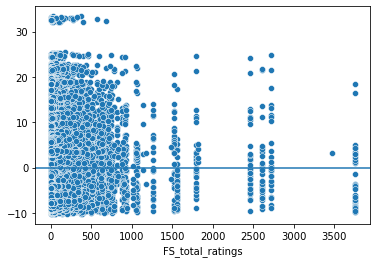

In [17]:
ax = sns.scatterplot(x=POI_df['FS_total_ratings'], y=residuals)
ax.axhline(0) #horizontal line at 0

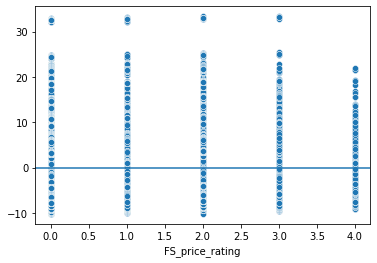

In [27]:
ax = sns.scatterplot(x=POI_df['FS_price_rating'], y=residuals)
ax.axhline(0) #horizontal line at 0

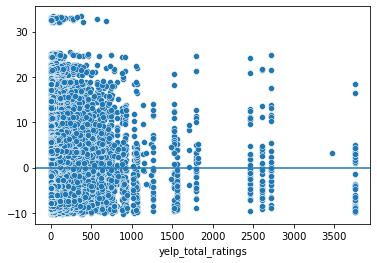

In [28]:
ax = sns.scatterplot(x=POI_df['yelp_total_ratings'], y=residuals)
ax.axhline(0) #horizontal line at 0

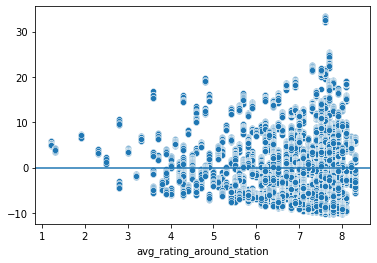

In [29]:
ax = sns.scatterplot(x=POI_df['avg_rating_around_station'], y=residuals)
ax.axhline(0) #horizontal line at 0

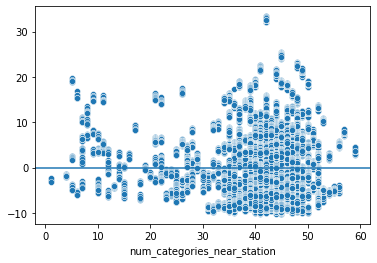

In [30]:
ax = sns.scatterplot(x=POI_df['num_categories_near_station'], y=residuals)
ax.axhline(0) #horizontal line at 0

### I have to be honest, I don't know exactly what I'm looking at or whether I did it correctly, but in many cases the spread of residuals does not necessarily appear constant across the range of values of each predictor variable.  We even have some discernable shapes like residuals spreading out/fanning apart as the values of the predictor variable increases, or the straight lines for the categorical values.  It appears that homoscedasticity  is not met in all cases.

### Let's Normalize our data, and run the regression model again.

In [32]:
# Using the MinMax Scaler on the data to normalize it
normalized_X = pd.DataFrame(MinMaxScaler().fit_transform(refined_X), columns=refined_X.columns)

lin_reg = sm.OLS(y,normalized_X)
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:        number of bikes   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                          1.577e+04
Date:                Wed, 30 Aug 2023   Prob (F-statistic):                        0.00
Time:                        23:59:54   Log-Likelihood:                     -1.8684e+05
No. Observations:               56282   AIC:                                  3.737e+05
Df Residuals:                   56276   BIC:                                  3.737e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

### These results are not unexpected given what we had written above about the coefficients before normalization.  Now that the data is normalized, it is easier to identify the impacts of each predictor.  

### Let's now check the distributions of each of these (now normalized) predictors

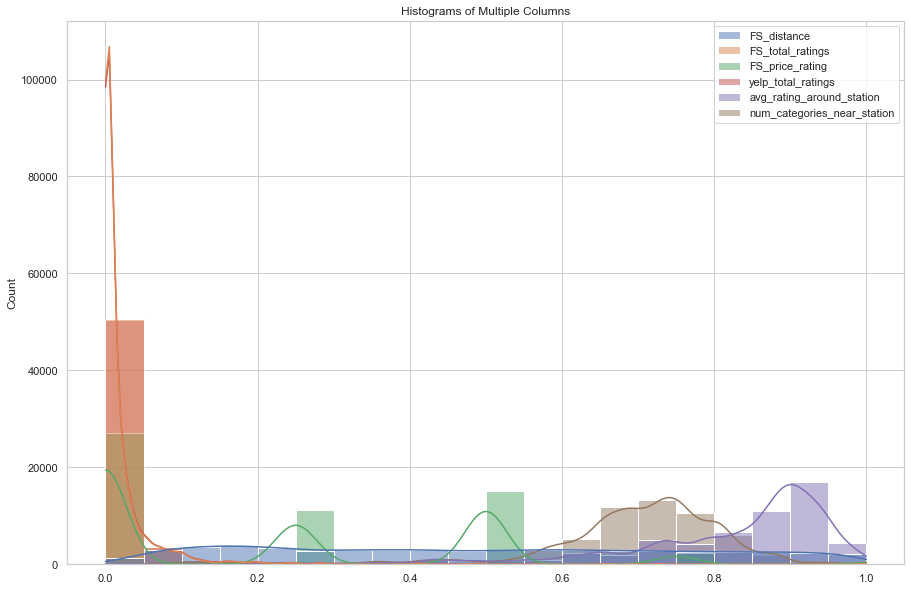

In [33]:
# Let's check the distributions of these predictors:
def plot_histograms_seaborn(X):
    plt.figure(figsize=(15, 10))
    sns.set(style='whitegrid')
    sns.histplot(data=X, bins=20, kde=True)
    plt.title("Histograms of Multiple Columns")
    plt.show()
    
plot_histograms_seaborn(normalized_X)

#### These distributions do NOT look good at all.  Let's discuss this a little in more detail why I suspect we are seeing what we are seeing.
- We have a tonne of price ratings that were zero since many POIs did not have a rating for price.  

- We also see that there are alot of 0s for both the FS and yelp total ratings.  Once again, this is because we had a lot of POIs that did not provide this information.  

- There is a near flat distribution for FS_distance, which makes sense, because the POIs returned for each FS or Yelp API call would be fairly evenly distributed between 10 to 1000 meters away.  

- Our PF_price_rating is just a number of peaks, since it's a categorical value and cannot have values other than 0, 1, 2, 3, or 4 (before normalization).  

- The only distributions that are somewhat normal are the distributions for num_categories_near_station and avg_rating_around_station.  This is not a surprise, since these were the only two engineered values that are station-centric.

### Because we see such poor distributions for many of these predictors, and given the break-down of the coefficents and their impacts, I've decided to remove all variables except for num_categories_near_station and avg_rating_around_station.


In [34]:
final_X = POI_df[['num_categories_near_station', 'avg_rating_around_station']]

In [35]:
lin_reg = sm.OLS(y,final_X)
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:        number of bikes   R-squared (uncentered):                   0.626
Model:                            OLS   Adj. R-squared (uncentered):              0.626
Method:                 Least Squares   F-statistic:                          4.712e+04
Date:                Thu, 31 Aug 2023   Prob (F-statistic):                        0.00
Time:                        00:00:03   Log-Likelihood:                     -1.8691e+05
No. Observations:               56282   AIC:                                  3.738e+05
Df Residuals:                   56280   BIC:                                  3.738e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

#### Even though our R-squared value dropped by 0.002 from earlier, I'm more satisfied with the distributions of the data that we are working with.

### This means that our final equation for predicting the number of bikes at any given station is:

### $$y = -0.0162x_1 + 1.3121x_2$$

#### where:
#### $y = \textrm{number of bikes}$, 
#### $x_1 = \textrm{number of categories near station}$,
#### $x_2 = \textrm{average rating around station}$

# Stretch

### How can you turn the regression model into a classification model?

#### We could instead of having a numerical count of bikes, we could classify the number of bikes as low, medium, or high with each being a particular percentage of available bikes/total bike slots.  More specifically:
- Low: 0 - 30% full
- Medium: 30 - 70% full
- High: 71 - 100% full

#### For example, if a station had a total of 35 bike slots, with 26 of those bikes available, it would have 23/35 = 65.7% bike availability and therefore be classified as "medium" fullness.